### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 5. Random Forest Classifer 

#### Audrey Hughes Rager
#### December 30, 2020



## Import Python Packages

In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw
import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [2]:
#Import csv files into Pandas data frames
#reddf = pd.read_csv('winequality-red.csv',sep=";")
whitedf = pd.read_csv('winequality-white.csv',sep=";")
df = pd.read_csv('winequality-white.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)

df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


<h2>Identifying and Removing Outliers</h2>
<p>A predictor variable is considered to be an outlier only if it is > Q<sub>3</sub> + 1.5 IQR. Because all skewed data are positively skewed, we only need to eliminate those values.</p>

In [3]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    
    
   

In [4]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,6.809048,0.263828,0.322749,6.352759,0.042299,34.730575,136.953176,0.993844,3.189043,0.481445,10.592035,5.953936
std,0.726417,0.076298,0.083076,4.905477,0.009889,14.941739,41.049024,0.002877,0.137980,0.098904,1.214421,0.856194
min,4.900000,0.080000,0.110000,0.600000,0.016000,2.000000,19.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991580,3.100000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993520,3.180000,0.470000,10.500000,6.000000
75%,7.300000,0.310000,0.370000,9.600000,0.049000,45.000000,166.000000,0.995870,3.280000,0.540000,11.400000,6.000000
max,8.700000,0.485000,0.540000,20.800000,0.071000,78.000000,253.000000,1.001960,3.570000,0.760000,14.200000,9.000000


## EDA

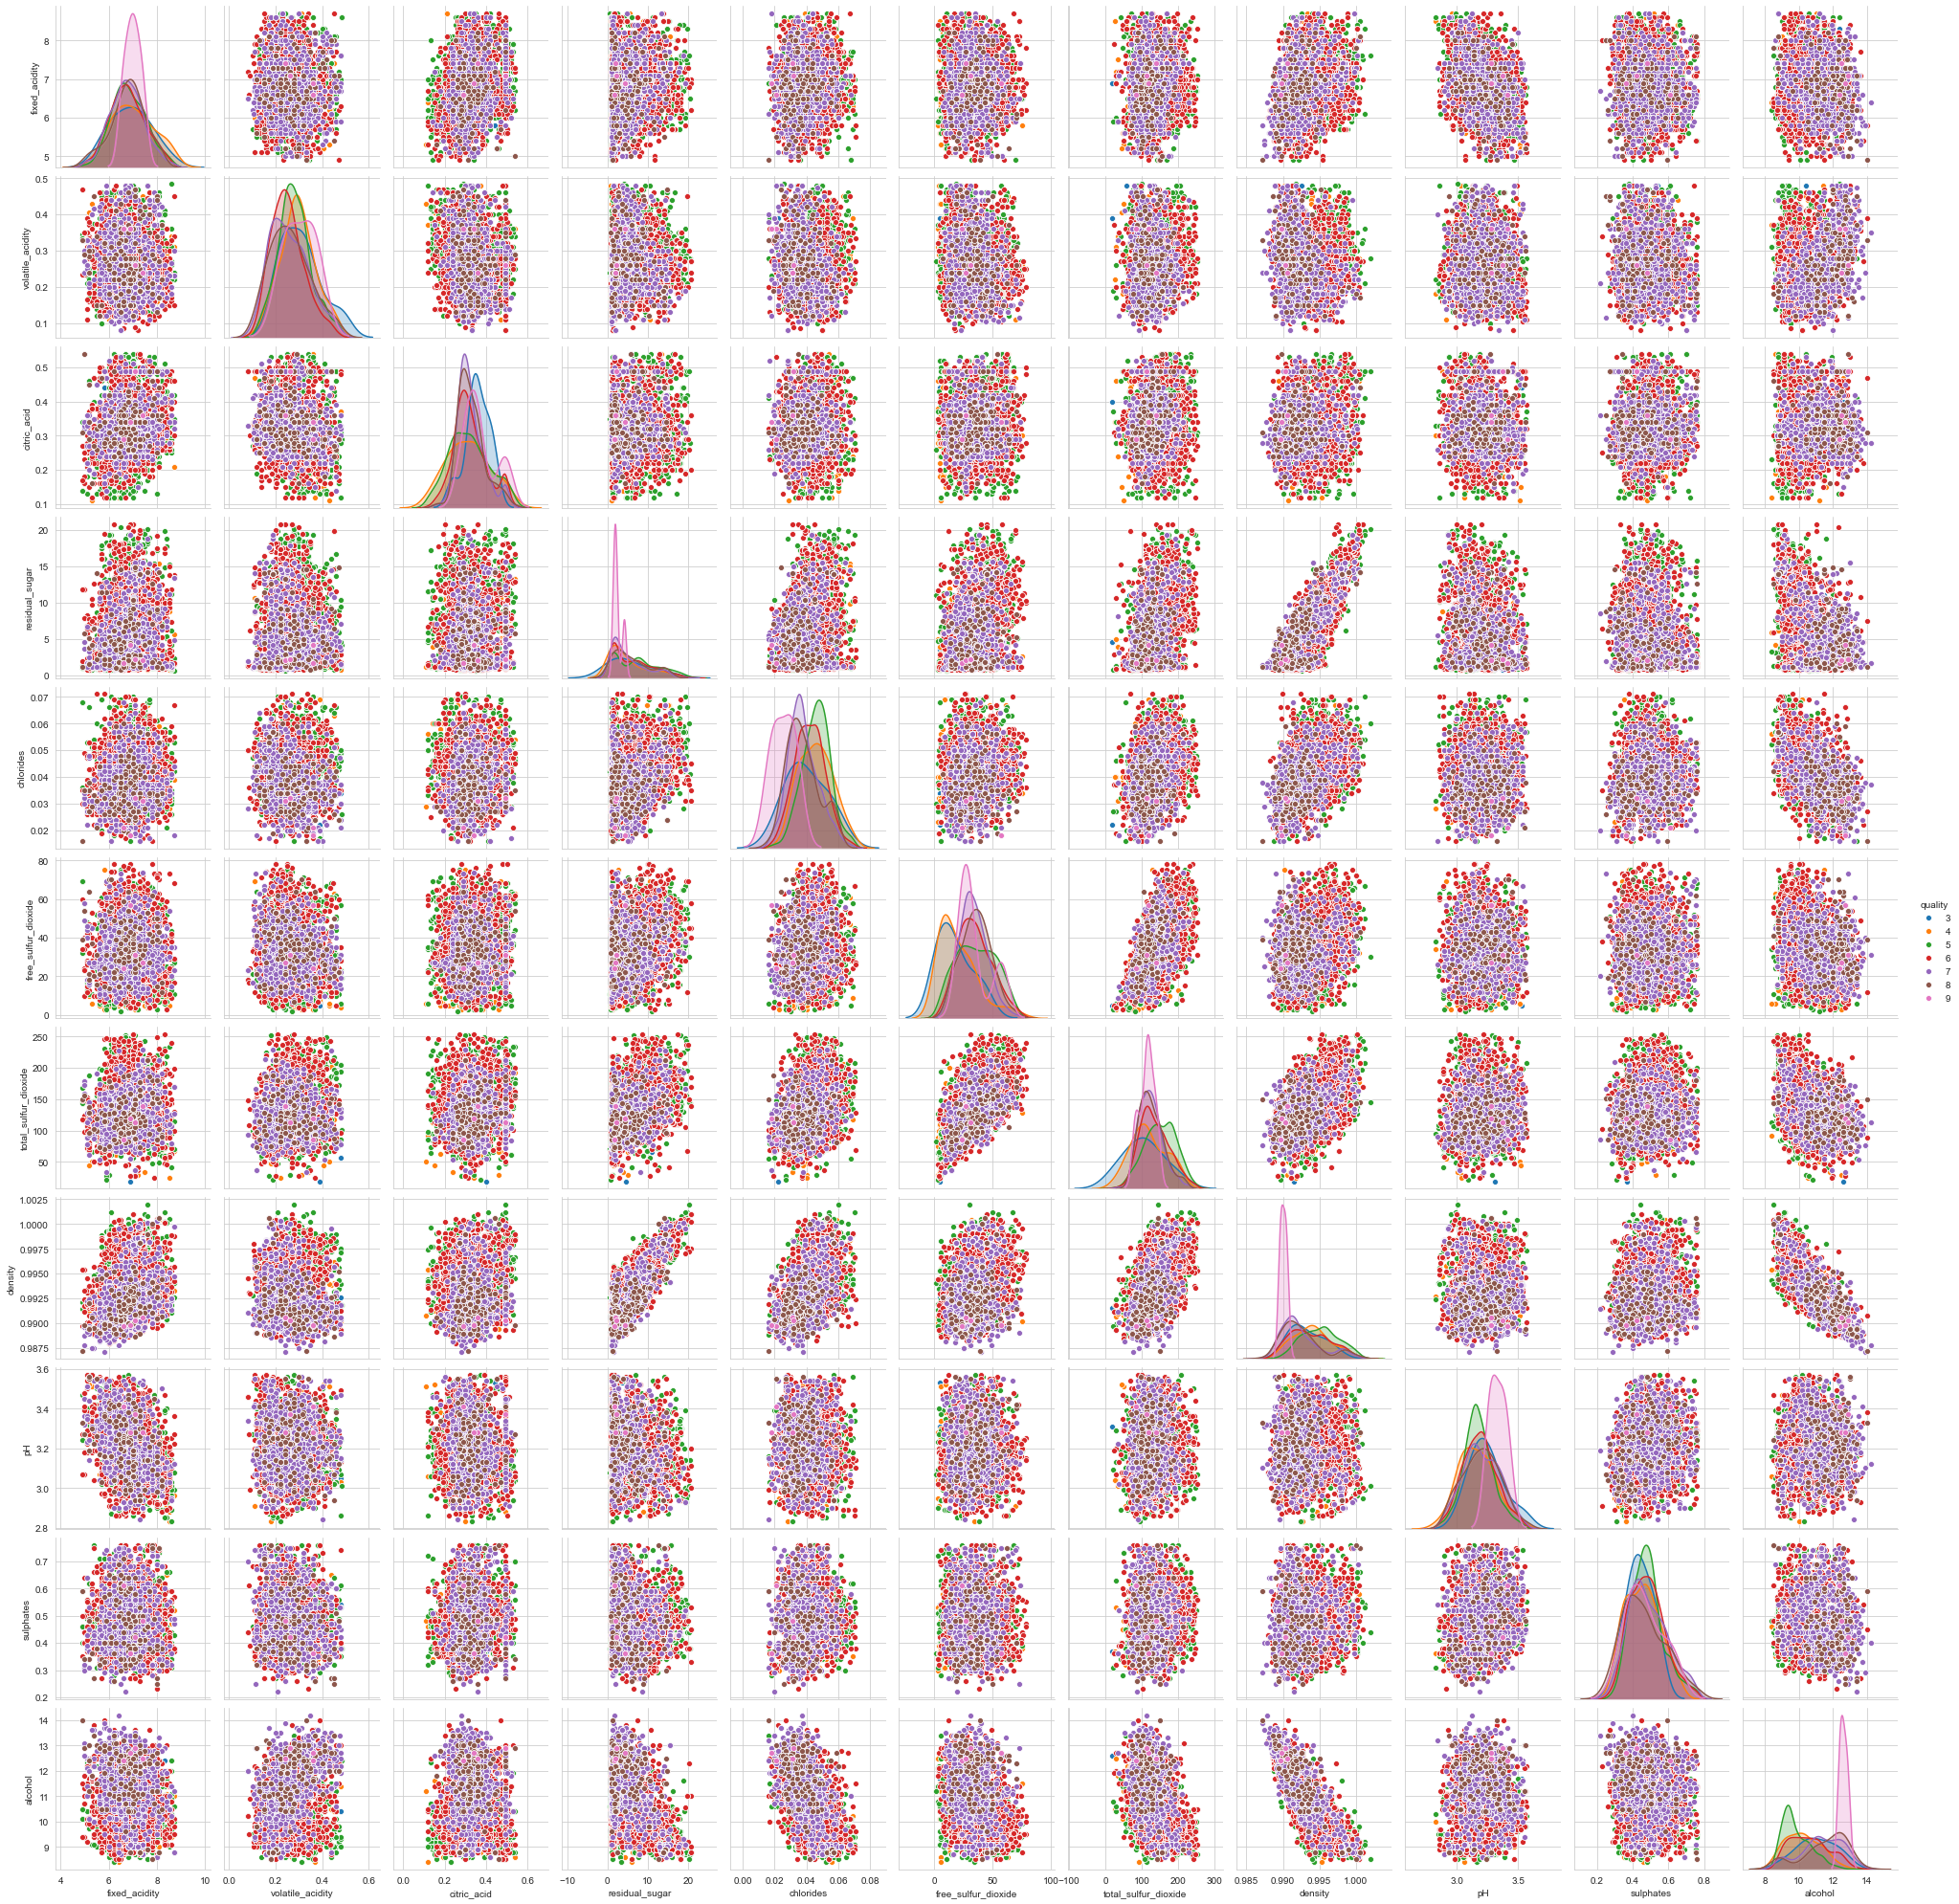

In [5]:
sns.pairplot(df,hue='quality')

## Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop('quality',axis=1)
y = df['quality']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


## Decision Trees


In [9]:
#Start with a single decision tree
from sklearn.tree import DecisionTreeClassifier

In [10]:
dtree = DecisionTreeClassifier()

In [11]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Prediction and Evaluation 


In [12]:
predictions = dtree.predict(X_test)

In [13]:
from sklearn.metrics import classification_report,confusion_matrix

In [14]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.40      0.33      0.36        30
           5       0.59      0.65      0.62       307
           6       0.69      0.61      0.65       565
           7       0.57      0.59      0.58       243
           8       0.34      0.57      0.43        40
           9       0.00      0.00      0.00         1

    accuracy                           0.61      1186
   macro avg       0.37      0.40      0.38      1186
weighted avg       0.62      0.61      0.61      1186



In [15]:
print(confusion_matrix(y_test,predictions))

[[  0   0   0   0   0   0   0]
 [  0  10  10   5   1   4   0]
 [  0   3 201  80  19   4   0]
 [  1  10 110 346  77  21   0]
 [  0   2  17  64 144  15   1]
 [  0   0   1   7   9  23   0]
 [  0   0   0   0   1   0   0]]


## Tree Visualization


### Print Text Representation

In [16]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [17]:
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X,y)

In [18]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_10 <= 10.85
|   |--- feature_1 <= 0.24
|   |   |--- feature_10 <= 8.75
|   |   |   |--- feature_0 <= 7.10
|   |   |   |   |--- feature_2 <= 0.30
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- feature_2 >  0.30
|   |   |   |   |   |--- feature_1 <= 0.16
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- feature_1 >  0.16
|   |   |   |   |   |   |--- feature_5 <= 25.50
|   |   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |   |--- feature_5 >  25.50
|   |   |   |   |   |   |   |--- class: 6
|   |   |   |--- feature_0 >  7.10
|   |   |   |   |--- feature_10 <= 8.55
|   |   |   |   |   |--- class: 8
|   |   |   |   |--- feature_10 >  8.55
|   |   |   |   |   |--- class: 7
|   |   |--- feature_10 >  8.75
|   |   |   |--- feature_5 <= 11.50
|   |   |   |   |--- feature_3 <= 3.10
|   |   |   |   |   |--- feature_0 <= 8.25
|   |   |   |   |   |   |--- feature_7 <= 0.99
|   |   |   |   |   |   |   |--- feature_0 <= 5.85
|   |   |   |   |   |   |   |   |-

### Plot Tree with plot_tree

[Text(172.80897376439353, 214.14545454545456, 'X[10] <= 10.85\ngini = 0.666\nsamples = 3951\nvalue = [9, 87, 1071, 1847, 788, 145, 4]'),
 Text(69.5179184378148, 207.55636363636364, 'X[1] <= 0.237\ngini = 0.621\nsamples = 2364\nvalue = [4, 63, 923, 1096, 243, 35, 0]'),
 Text(6.064799326565702, 200.96727272727273, 'X[10] <= 8.75\ngini = 0.606\nsamples = 934\nvalue = [1, 13, 205, 523, 164, 28, 0]'),
 Text(1.4885685504880337, 194.37818181818182, 'X[0] <= 7.1\ngini = 0.583\nsamples = 29\nvalue = [0, 0, 6, 5, 17, 1, 0]'),
 Text(0.7442842752440169, 187.7890909090909, 'X[2] <= 0.295\ngini = 0.569\nsamples = 12\nvalue = [0, 0, 6, 5, 1, 0, 0]'),
 Text(0.37214213762200843, 181.2, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 5, 0, 0, 0, 0]'),
 Text(1.1164264128660253, 181.2, 'X[1] <= 0.16\ngini = 0.449\nsamples = 7\nvalue = [0, 0, 1, 5, 1, 0, 0]'),
 Text(0.7442842752440169, 174.6109090909091, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0, 0, 0, 0]'),
 Text(1.4885685504880337, 174.6109090909091, 'X[5] 

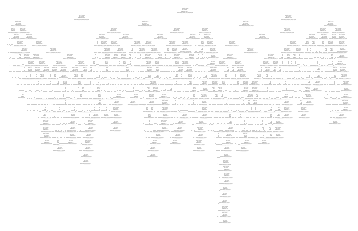

In [19]:
tree.plot_tree(clf)

## Random Forests


In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
rfc_pred = rfc.predict(X_test)

In [22]:
print(confusion_matrix(y_test,rfc_pred))

[[  5  15  10   0   0   0]
 [  1 199 104   3   0   0]
 [  1  78 441  44   1   0]
 [  0   4  95 143   1   0]
 [  0   0  13   6  21   0]
 [  0   0   1   0   0   0]]


In [23]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           4       0.71      0.17      0.27        30
           5       0.67      0.65      0.66       307
           6       0.66      0.78      0.72       565
           7       0.73      0.59      0.65       243
           8       0.91      0.53      0.67        40
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1186
   macro avg       0.62      0.45      0.49      1186
weighted avg       0.69      0.68      0.68      1186

